**Author**: JW Debelius<br>
**Date**: 2021-05<br>
**Conda enviroment**: `micc-2020.11`<br>
**QIIME 2 version**: 2020.11<br>
**QIIME 2 plugins**: `gemeilli` (v. 0.0.7); `deicode` (v. 0.2.4)'; `empress` (v 1.1.0.dev)<br>

The objective of this notebook is to build a descriptive taxonomic plot of paired tumor and normal muscoal microbiome samples for the MiCC project. 

In [1]:
import itertools as it
import os

import biom
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

from qiime2 import Artifact, Metadata
import qiime2.plugins.feature_table.actions as q2_feature_table

import scripts.tax_colors as tax_colors

rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
# rcParams['pdf.fonttype'] = 42
np.set_printoptions(precision=5, suppress=True)

%matplotlib inline

In [2]:
meta_q2 = Metadata.load('data/metadata_paired.tsv')
meta = meta_q2.to_dataframe()
alpha = Artifact.load('data/diversity/alpha/observed_features.qza').view(pd.Series)
meta['observed_asvs'] = (alpha - alpha.mean()) / alpha.std()
meta_q2 = Metadata(meta)
meta['long_survival'] = meta['long_survival'].astype(int)

In [3]:
table_q2 = Artifact.load('data/tables/table.qza')
table_q2 = \
    q2_feature_table.filter_samples(table=table_q2, 
                                    metadata=meta_q2).filtered_table


In [4]:
taxa_q2 = Artifact.load('data/tables/taxonomy.qza')
taxa = taxa_q2.view(pd.Series).apply(lambda x: pd.Series(x.split(';')))
taxa = taxa.loc[list(table_q2.view(biom.Table).ids(axis='observation'))]

# there is a specific place where the family belongs to two classes and so we 
# have to specify which if we want to shorten them, which is beyond annoying. 
taxa.loc[taxa[[3, 4]].isin(['f__Family_XI', 'c__Clostridia']).all(axis=1), 4] = \
    'f__Family_XI (c__Clostridia)'
taxa.loc[taxa[[3, 4]].isin(['f__Family_XI', 'c__Bacilli']).all(axis=1), 4] = \
    'f__Family_XI (c__Bacilli)'
taxa.rename(columns={0: 'kingdom', 1: 'phylum', 2: 'class',
                     3: 'order', 4: 'family', 5: 'genus', 
                     6: 'species'},
            inplace=True)
taxa['color_group'] = \
    taxa['family'].apply(lambda x: tax_colors.remappings.get(x, 'Other|Other'))

In [5]:
collapse_order = ['p__Firmicutes|f__Lachnospiraceae',
                  'p__Firmicutes|f__Ruminococcaceae',
                  'p__Firmicutes|c__Clostridia',
                  'p__Firmicutes|c__Bacilli',
                  'p__Firmicutes|p__Firmicutes',
                  'p__Bacteroidetes|f__Bacteroidaceae',
                  'p__Bacteroidetes|f__Rikenellaceae',
                  'p__Bacteroidetes|f__Porphyromonadaceae',
                  'p__Bacteroidetes|f__Prevotellaceae',
                  'p__Fusobacteria|f__Fusobacteriaceae',
                  'p__Proteobacteria|c__Gammaproteobacteria',
                  'p__Proteobacteria|p__Proteobacteria',
                  'p__Actinobacteria|f__Bifidobacteriaceae',
                  'p__Verrucomicrobia|f__Verrucomicrobiaceae',
                  'Other|Other',
                  ]

In [6]:
table = table_q2.view(biom.Table)
table.add_metadata(taxa.to_dict(orient='index'), axis='observation')
collapsed = table.collapse(
    lambda id_, md: ('Other|Other' if md['color_group'] == 'Other|Other' 
                     else '|'.join([md['phylum'], md['color_group']])), 
    axis='observation', 
    norm=False)
collapsed = collapsed.norm(axis='sample').to_dataframe().sparse.to_dense()
collapsed.rename(index={c: 'Other|Other' 
                        for c, v in collapsed.mean(axis=1).items() 
                        if (v < 0.01)},
                 inplace=True
                 )
collapsed.index.set_names('taxonomy', inplace=True)
collapsed = collapsed.groupby('taxonomy', sort=False).sum().loc[collapse_order].T

collapsed[['subject', 'tissue', 'survival']] = \
    meta[['host_subject_id', 'tissue_type', 'long_survival']]
collapsed['firmicutes_mean'] = \
    collapsed.groupby('subject').mean()[collapse_order[:5]].sum(axis=1).loc[
        collapsed['subject'].values].values
collapsed.sort_values(['survival', 'firmicutes_mean', 'tissue'], 
                      ascending=True, inplace=True)


collapsed.loc[collapsed['tissue'] == 'normal', 'hsi_x'] = 2.25
collapsed['hsi_x'] = collapsed['hsi_x'].cumsum() - 1
collapsed['hsi_x'] = \
    collapsed.groupby('subject')['hsi_x'].fillna(method='ffill')
collapsed['tissue_x'] = (1 - (collapsed['tissue'] == 'normal') * 2) * 0.5
collapsed['x'] = \
    collapsed[['tissue_x', 'hsi_x']].sum(axis=1) + collapsed['survival'] * 15

# collapsed.set_index('x', inplace=True)


survive_mean = collapsed.groupby(['survival', 'tissue']).mean()[collapse_order]
survive_mean_x = \
    collapsed.groupby(['survival', 'tissue'])['x'].max()
survive_mean_x = \
    survive_mean_x + (survive_mean.index.to_frame()['tissue'] == 'tumor') * 2
survive_mean_x = survive_mean_x + 7.5

collapsed.set_index('x', inplace=True)
height = collapsed[collapse_order].T
bottom = height.cumsum(axis=0) - height

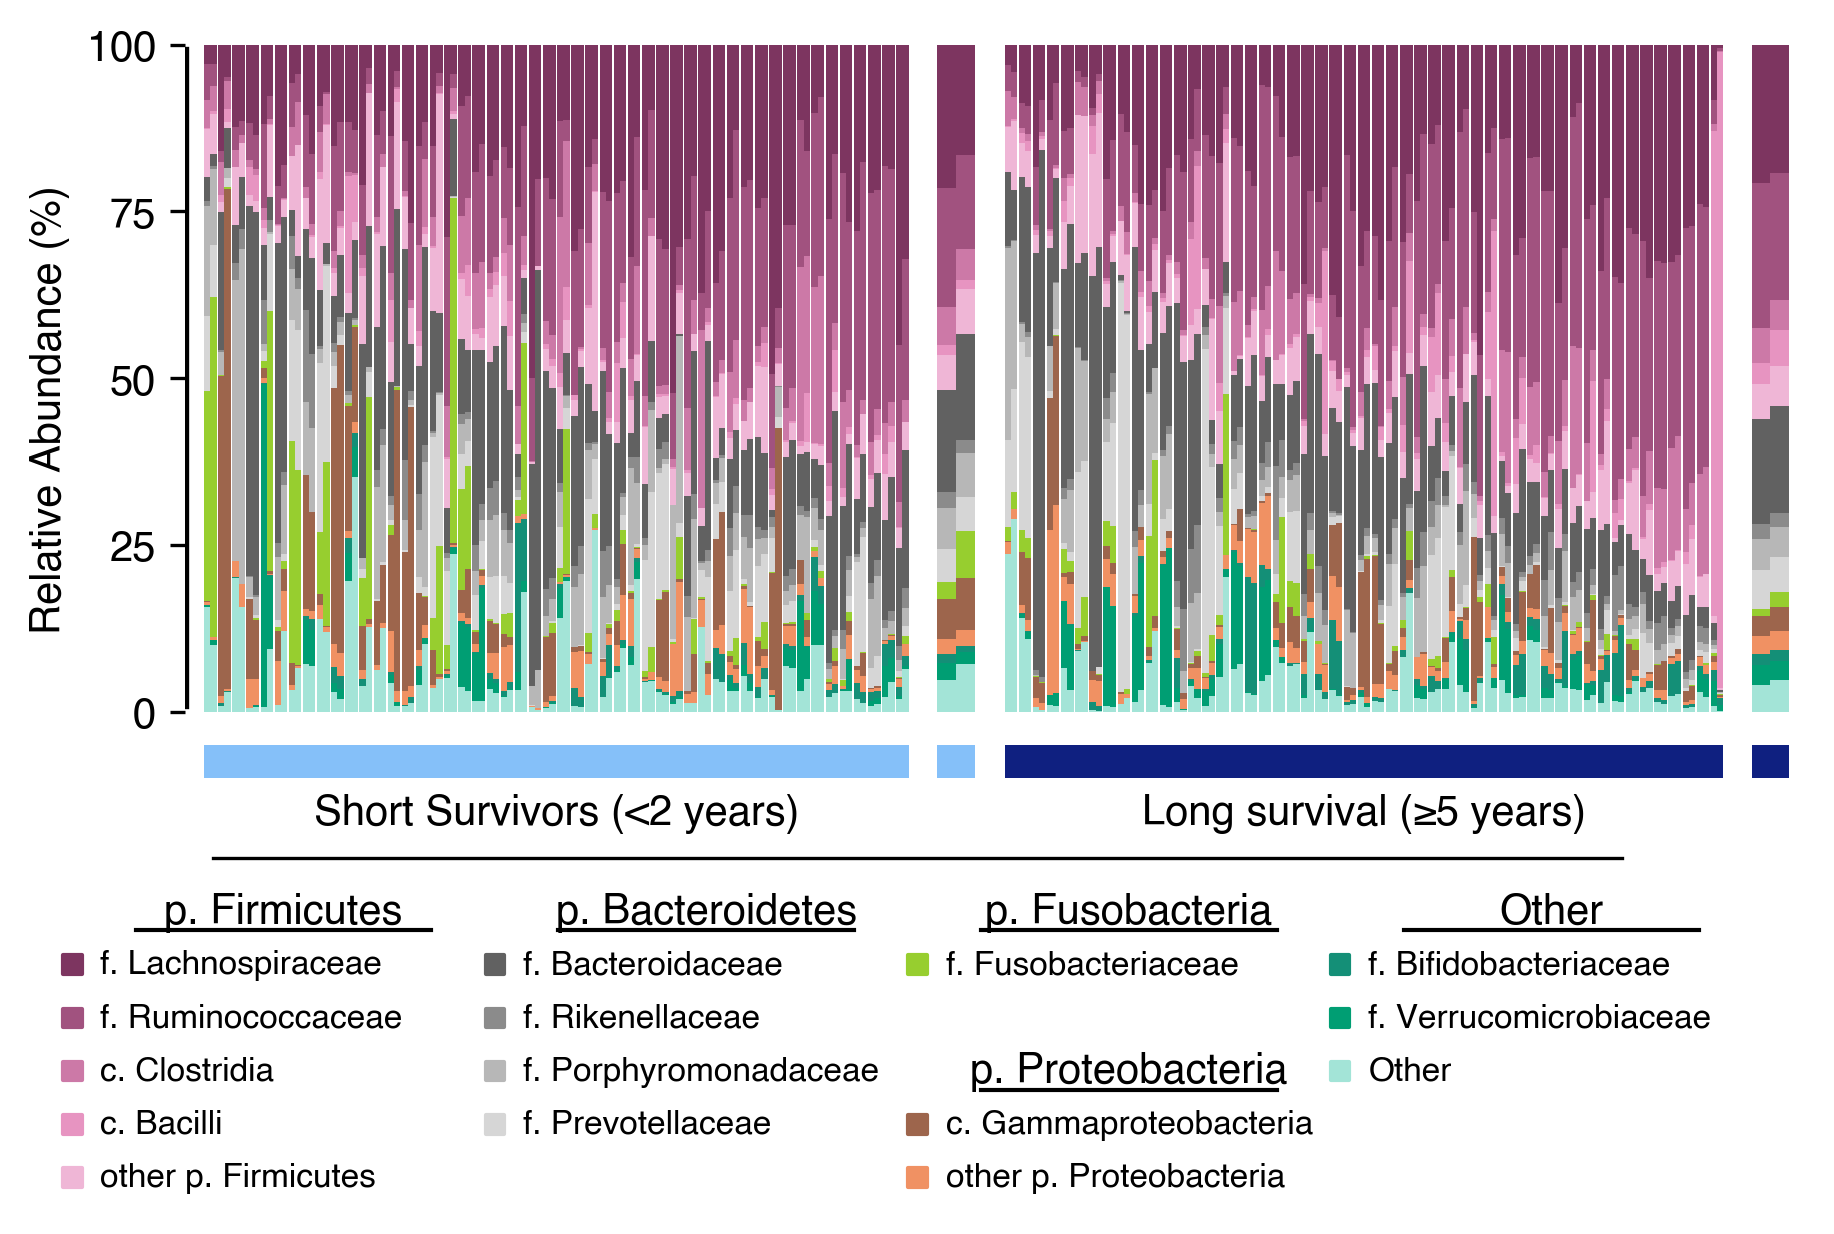

In [7]:
fig = plt.figure(constrained_layout=True, dpi=300, 
                 figsize=(6, 4), facecolor='None')
gs = fig.add_gridspec(3, 1)
ax = fig.add_subplot(gs[:-1, :])

for level, h in height.iterrows():
    ax.bar(
        x=h.index,
        bottom=bottom.loc[level],
        height=h,
        color=tax_colors.mapped_colors[level.split('|')[1]],
        width=1,
    )
    ax.bar(
        x=survive_mean_x,
        bottom=survive_mean.cumsum(axis=1)[level] - survive_mean[level],
        height=survive_mean[level],
        color=tax_colors.mapped_colors[level.split('|')[1]],
        width=3,
    )
x_range = \
   collapsed.groupby('survival').apply(
        lambda x: pd.Series([x.index.min(), x.index.max()]))
for i, color in enumerate(['#0f2080', '#85c0f9'][::-1]):
    ax.fill_between(
        x=np.array([-0.5, 0.5]) + x_range.loc[i],
        y1=[1.05, 1.05], 
        y2=[1.1, 1.1], 
        color=color,
        edgecolor=None,
        )
    ax.fill_between(
        x=survive_mean_x.loc[i] + np.array([-1.5, 1.5]),
        y1=[1.05, 1.05], 
        y2=[1.1, 1.1], 
        color=color,
        edgecolor=None,
        )

ax.set_xlim(x_range[0].min() - 3.5, survive_mean_x[1].max() + 4)
ax.set_ylim([1.101, -0.01])
ax.set_yticks(np.arange(1, -0.01, -0.25))
ax.set_yticklabels(np.arange(0, 101, 25))
ax.set_ylabel('Relative Abundance (%)')
ax.set_xticks(x_range.mean(axis=1))
ax.set_xticklabels(['Short Survivors (<2 years)', 'Long survival (≥5 years)'])
ax.xaxis.set_tick_params(length=0, bottom=False)
sn.despine(ax=ax, left=True, right=True, top=True, bottom=True)
ax.plot([collapsed.index.min() - 3.5] * 2, [0.01, 0.99], 'k-', linewidth=2)

ax_leg = fig.add_subplot(gs[-1, :].subgridspec(1,1)[:, :])
ax_leg.set_xlim([-0.15, 6.15])
ax_leg.set_ylim([-0.5, 6])
labels = [c.split('|')[1] for c in collapse_order]
labelx = np.hstack([np.zeros(5), np.ones(4),  np.ones(3) * 2, 
                    np.ones(3) * 3]) * 1.5
labely = np.hstack([np.arange(4, -1, -1), np.arange(4, 0, -1), 
                    np.array([4, 1, 0]), np.array([4, 3, 2])
                   ])
phy = ['p__Firmicutes', 'p__Bacteroidetes', 'p__Fusobacteria', 
       'p__Proteobacteria', 'Other']
phyx = np.array([[0, 1, 2, 2, 3],
                 [1, 2, 3, 3, 4]]) * 1.5

phyy = np.array([5, 5, 5, 2, 5])

ax_leg.scatter(
    labelx, labely,
    marker='s',
    c=pd.Series(tax_colors.mapped_colors).loc[labels],
    s=20,
    #bar_colors.values
)
for x, y, l in zip(*(labelx, labely, labels)):
    ax_leg.text(x + 0.1, y, 
                l.replace("p__", "other p__").replace("__", '. '), 
                ha='left', 
                va='center',
                size=8,
                )
for xs, y, l in zip(*(phyx.T, phyy, phy)):
    ax_leg.plot(xs + np.absolute(np.diff(xs)) * np.array([0.15, -0.15]),
            np.array([y] * 2) - 0.35,
            'k-',
            linewidth=1)
    ax_leg.text(np.mean(xs), y, l.replace("__", '. '), size=10, 
            ha='center', va='center')
#
ax_leg.set_xticks([0.5, 5.5])
ax_leg.xaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=False)
ax_leg.yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=False)
sn.despine(ax=ax_leg, left=True, right=True, top=False, bottom=True, trim=True)
ax_leg.xaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=False)


!mkdir -p output/figures
fig.savefig('output/figures/figure_s1_stacked_barchart.png', dpi=300, facecolor='None')
fig.savefig('output/figures/figure_s1_stacked_barchart.pdf')
